# Analyze Visibility Metrics 

In [15]:
%matplotlib notebook

import os 
import re 
import pytz
import glob 
import json
import unicodedata

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt 

from dateutil.parser import parse as parse_ts

from datetime import datetime, timedelta 
from collections import defaultdict

sns.set_style('white')
sns.set_context('notebook')

In [2]:
DATA = "../data"
RUNS = "run-*"
FIGS = "../figures"
HOSTS = "hosts.json"
RESULTS = "visibile_versions-*.log"
CONFIGS = "config-*.json"


def suffix(path):
    # Get the run id from the path 
    name, _ = os.path.splitext(path)
    return int(name.split("-")[-1]) 


def load_hosts(path=DATA):
    with open(os.path.join(path, HOSTS), 'r') as f:
        return json.load(f)


def load_configs(path=DATA):
    configs = {}
    for name in glob.glob(os.path.join(path, CONFIGS)):
        with open(name, 'r') as f:
            configs[suffix(name)] = json.load(f)
    return configs 


def slugify(name):
    slug = unicodedata.normalize('NFKD', name)
    slug = str(slug.encode('ascii', 'ignore')).lower()
    slug = re.sub(r'[^a-z0-9]+', '-', slug).strip('-')
    slug = re.sub(r'[-]+', '-', slug)
    return slug 


def load_raw_results(path=DATA):
    for run_path in glob.glob(os.path.join(path, RUNS)):
        run = suffix(run_path)
        
        for host in os.listdir(run_path):
            for result in glob.glob(os.path.join(run_path, host, RESULTS)):
                exp = suffix(result) 
                
                with open(result, 'r') as f:
                    for line in f:
                        row = json.loads(line.strip())
                        row['name'] = host 
                        row['runid'] = run 
                        row['expid'] = exp 
                        yield row

                        
def _load_results(path=DATA):
    versions = defaultdict(list)
    for row in load_raw_results(path):
        vers = "{Key} {Version} {runid}-{expid}".format(**row)
        result = {key: row[key] for key in ('name', 'expid', 'runid')}
        result['timestamp'] = parse_ts(row['Timestamp'])
        
        versions[vers].append(result)
    
    configs = load_configs(path) 
    for version, values in versions.items():
        expid = values[0]['expid']
        conf = configs[expid]
        
        ts = np.array([r['timestamp'] for r in values])
        hosts = np.array([r['name'] for r in values])
        origin = hosts[np.argmin(ts)]
        origin = " ".join(origin.split("-")[1:-1]).title()
                        
        n_hosts = len(np.unique(hosts))
        t_hosts = len(conf['replicas']['hosts'])
        
        
        exp = conf['replicas']['config']['bandit']
        epsilon = conf['replicas']['config'].get('epsilon', None)
        if epsilon:
            exp += " ε={}".format(epsilon)
        
        yield {
            'version': version, 
            'bandit': exp,
            'expid': expid, 
            'runid': values[0]['runid'], 
            'n_hosts': n_hosts, 
            'max_ts': max(ts), 
            'min_ts': min(ts), 
            'latency': (max(ts) - min(ts)).total_seconds(), 
            'visibility': n_hosts / t_hosts, 
            'origin': origin, 
        }
                        

def load_results(data=DATA, refresh=False):
    csv = os.path.join(data, "visibility.csv")
    if os.path.exists(csv) and not refresh:
        return pd.read_csv(csv)
    
    df = pd.DataFrame(_load_results(data))
    df.to_csv(csv)
    return df 

In [3]:
data = load_results()
exps_sorted = sorted(data['bandit'].unique())
origins_sorted =[
    "Oregon",
    "California",
    "Ohio",
    "Virginia",
    "Canada",
    "Sao Paulo",
    "Ireland",
    "London",
    "Paris",
    "Frankfurt",
    "Mumbai",
    "Singapore",
    "Seoul",
    "Tokyo",
    "Sydney",
]

In [4]:
data.head()

,Unnamed: 0,bandit,expid,latency,max_ts,min_ts,n_hosts,origin,runid,version,visibility
0,0,epsilon ε=0.5,4,1.993611,2018-03-14 21:22:42.328717+00:00,2018-03-14 21:22:40.335106+00:00,45,Canada,0,AUN 1437333.23 0-4,1.0
1,1,epsilon ε=0.5,4,1.787623,2018-03-14 21:22:41.699045+00:00,2018-03-14 21:22:39.911422+00:00,45,Virginia,0,GIJ 1433790.35 0-4,1.0
2,2,epsilon ε=0.5,4,2.032995,2018-03-14 21:22:42.328712+00:00,2018-03-14 21:22:40.295717+00:00,45,Ohio,0,IUN 1434599.39 0-4,1.0
3,3,epsilon ε=0.5,4,1.587318,2018-03-14 21:22:42.594845+00:00,2018-03-14 21:22:41.007527+00:00,45,Paris,0,EOL 1440507.5 0-4,1.0
4,4,epsilon ε=0.5,4,1.917230,2018-03-14 21:22:42.800058+00:00,2018-03-14 21:22:40.882828+00:00,45,London,0,JUN 1437922.8 0-4,1.0


In [6]:
data.groupby('bandit')['expid', 'visibility'].mean()

,expid,visibility
bandit,,
annealing,5,0.998370
epsilon ε=0.1,2,0.997827
epsilon ε=0.2,3,0.998370
epsilon ε=0.5,4,0.999457
uniform,1,0.998370


In [7]:
data.groupby('bandit')['expid', 'latency'].mean()

,expid,latency
bandit,,
annealing,5,1.885273
epsilon ε=0.1,2,1.942640
epsilon ε=0.2,3,1.904711
epsilon ε=0.5,4,1.872728
uniform,1,2.358490


<IPython.core.display.Javascript object>


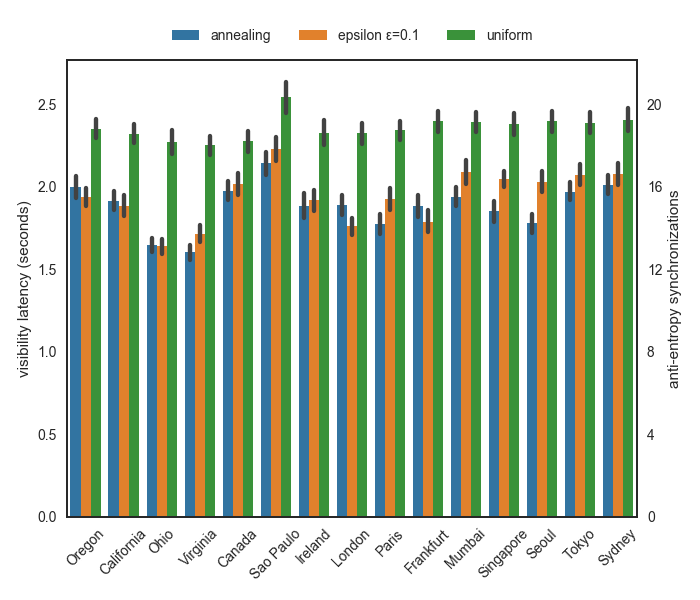

In [42]:
def filter_by_experiment_ids(data, expids):
    if isinstance(expids, (list, tuple)):
        mask = (data.expid == None)
        for expid in expids:
            mask = mask | (data.expid == expid)
        data = data[mask]
    
    return data 


def latency_graph(data=data, expids=None, order=None, by_region=False, outpath=None):
    
    def n_syncs(X):
        V = (X * 1000) / 125
        return ["{:0.0f}".format(z) for z in V]
    
    fig, ax = plt.subplots(figsize=(7,6))
    
    data = filter_by_experiment_ids(data, expids)
    
    if by_region:
        ax2 = ax.twinx()

        g = sns.barplot(x='origin', y='latency', hue='bandit', order=order, data=data, ax=ax)
        
        ax.set_xlabel("")
        ax.set_ylabel("visibility latency (seconds)")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
        new_tick_locations = ax.get_yticks()[:-1]
        
        ax2.set_ylim(ax.get_ylim())
        ax2.set_yticks(new_tick_locations)
        ax2.set_yticklabels(n_syncs(new_tick_locations))
        ax2.set_ylabel(r"anti-entropy synchronizations")
        
        ax.legend(bbox_to_anchor=(0,.88,1,0.2), loc="upper center", borderaxespad=0, ncol=3)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
    else:
        ax2 = ax.twinx()
        
        g = sns.barplot(x='bandit', y='latency', order=order, data=data, ax=ax)

        ax.set_xlabel("")
        ax.set_ylabel("visibility latency (seconds)")
        
        new_tick_locations = ax.get_yticks()[:-1]
        ax2.set_ylim(ax.get_ylim())
        ax2.set_yticks(new_tick_locations)
        ax2.set_yticklabels(n_syncs(new_tick_locations))
        ax2.set_ylabel(r"anti-entropy synchronizations")
    
        plt.tight_layout()

    if outpath:
        plt.savefig(outpath)
    
    return ax 


latency_graph(outpath=os.path.join(FIGS, "visibility_latency.pdf"), expids=(1,2,5), by_region=True, order=origins_sorted)
# latency_graph(outpath=os.path.join(FIGS, "visibility_latency_agg.pdf"), by_region=False, order=exps_sorted)

<IPython.core.display.Javascript object>


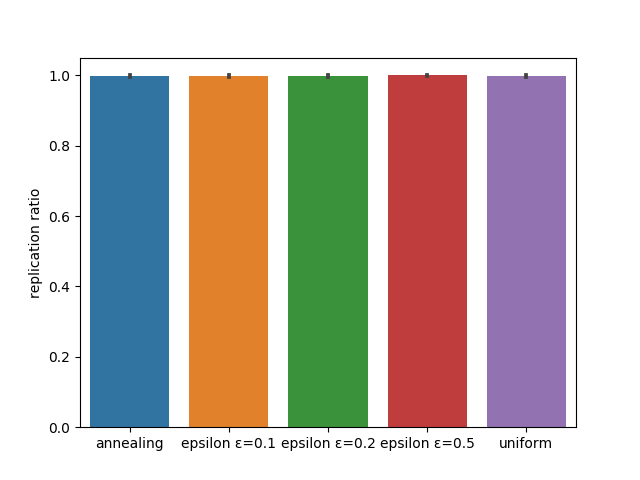

In [11]:
def percent_replication_graph(data=data, expids=None, order=exps_sorted, outpath=None):
    fig, ax = plt.subplots()
    
    data = filter_by_experiment_ids(data, expids) 
        
    sns.barplot(x=data.bandit, y=data.visibility, order=order, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("replication ratio")
    
    if outpath:
        plt.savefig(outpath)
    
    return ax 


# percent_replication_graph(expids=(1,4), order=None)
percent_replication_graph(outpath=os.path.join(FIGS, "percent_replication.pdf"))
# percent_replication_graph()